In [1]:
import os
import sys

import pandas as pd
import xarray as xr

import FINE as fn
import FINE.IOManagement.xarrayIO as xrIO

cwd = os.getcwd()

%load_ext autoreload
%autoreload 2

# Workflow for spatial aggregation of an energy system model

This example notebook shows how model regions can be merged to obtain fewer regions

<img src="figures/spatial_aggregation_for_example_notebook.png" style="width: 1000px;"/>

The figure above dipicts the basic idea behind spatial aggregation. The term spatial aggregation refers to grouping 
and subsequently merging the regions that are similar in some sense (NOTE: Please look into the documentation for 
different methods to group regions). 

## STEP 1. Set up your ESM instance 

In [2]:
from getModel import getModel

esM = getModel()

The distances of a component are set to a normalized value of 1.


 c:\users\t.gross\documents\programming\jugit\fine\FINE\utils.py:980: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


In [3]:
esM.locations

{'cluster_0',
 'cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7'}

## STEP 2. Spatial Aggregation

In [4]:
# The input data to spatial aggregation are esM instance and the shapefile containing model regions' geometries
SHAPEFILE_PATH = os.path.join(
    cwd,
    "..",
    "Multi-regional_Energy_System_Workflow/InputData/SpatialData/ShapeFiles/clusteredRegions.shp",
)

In [5]:
# Once the regions are grouped, the data witin each region group needs to be aggregated. Through the aggregation_function_dict
# parameter, it is possible to define/change how each variable show be aggregated. Please refer to the documentation for more
# information.

aggregation_function_dict = {
    "operationRateMax": ("mean", "capacityMax"),
    "operationRateFix": ("sum", None),
}

In [6]:
# You can provide a path to save the results with desired file names. Two files are saved - a shapefile containing
# the merged region geometries and a netcdf file containing the aggregated esM instance data.
shp_name = "aggregated_regions"
aggregated_xr_filename = "aggregated_xr_ds.nc"

In [7]:
# Spatial aggregation
aggregated_esM = esM.aggregateSpatially(
    shapefile=SHAPEFILE_PATH,
    grouping_mode="parameter_based",
    n_groups=4,
    aggregatedResultsPath=os.path.join(cwd, "output_data"),
    aggregation_function_dict=aggregation_function_dict,
    shp_name=shp_name,
    aggregated_xr_filename=aggregated_xr_filename,
    solver="glpk",
)

0 iteration: Solving instance
Total distance: 2205.2932322735014 with solving time: 0.13660120964050293
2 contiguity constraints/cuts added, adding to a total number of 2 cuts within time: 0.0
1 iteration: Solving instance
Total distance: 2768.01027082518 with solving time: 0.06249094009399414
6 contiguity constraints/cuts added, adding to a total number of 8 cuts within time: 0.015232086181640625
2 iteration: Solving instance
Total distance: 3210.31542914801 with solving time: 0.06904840469360352
0 contiguity constraints/cuts added, adding to a total number of 8 cuts within time: 0.0
elapsed time for perform_parameter_based_grouping: 0.05 minutes


 C:\Users\t.gross\Anaconda3\envs\dev_FINE\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


elapsed time for perform_spatial_aggregation: 0.16 minutes


 c:\users\t.gross\documents\programming\jugit\fine\FINE\utils.py:980: UserWarning:A declaration of bigM is not necessary if hasIsBuiltBinaryVariable is set to false. The value of bigM will be ignored in the optimization.


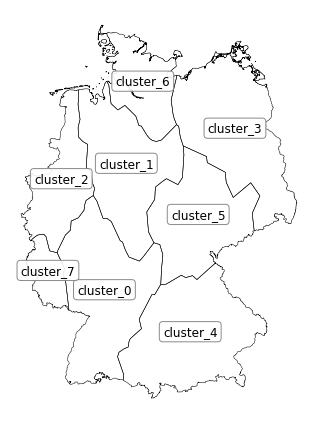

In [8]:
# Original spatial resolution
fig, ax = fn.plotLocations(SHAPEFILE_PATH, plotLocNames=True, indexColumn="index")

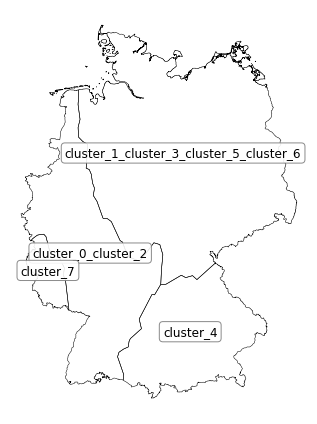

In [9]:
# Spatial resolution after aggregation
AGGREGATED_SHP_PATH = os.path.join(cwd, "output_data", f"{shp_name}.shp")

fig, ax = fn.plotLocations(AGGREGATED_SHP_PATH, plotLocNames=True, indexColumn="space")

In [10]:
# The locations in the resulting esM instance are now 4.
aggregated_esM.locations

{'cluster_0_cluster_2',
 'cluster_1_cluster_3_cluster_5_cluster_6',
 'cluster_4',
 'cluster_7'}

In [11]:
#  And corresponding data has also been aggregated
aggregated_esM.getComponentAttribute("Wind (onshore)", "operationRateMax")

space,cluster_0_cluster_2,cluster_1_cluster_3_cluster_5_cluster_6,cluster_4,cluster_7
time,,,,
0,0.778801,0.896089,0.276660,0.623974
1,0.779175,0.889352,0.275148,0.667338
2,0.772609,0.875346,0.286690,0.696272
3,0.762311,0.851198,0.303492,0.705269
4,0.740985,0.824188,0.324501,0.710336
...,...,...,...,...
8755,0.535852,0.515689,0.155183,0.426975
8756,0.510271,0.474827,0.119844,0.429161
8757,0.530000,0.432508,0.101342,0.507018


# Step 3. Temporal Aggregation

Although spatial aggregation aids in reducing the computational complexity of optimization, temporal aggregation is still necessary. 

Spatial aggregation is not here is replace temporal aggregation. They both go hand-in-hand. 

Imagine performing temporal aggregation on a model with too many regions. You have to reduce the temporal resolution to a large extent. Or you can take too few regions and reduce the temporal resolution to a smaller extent. 

With spatial and temporal aggregation, you need not compromise on either the temporal or spatial resolution of your model. 

In [12]:
aggregated_esM.aggregateTemporally(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(6.6021 sec)



 C:\Users\t.gross\Anaconda3\envs\dev_FINE\lib\site-packages\tsam\timeseriesaggregation.py:1070: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


# Step 5. Optimization

In [13]:
aggregated_esM.optimize(timeSeriesAggregation=True)
# The following `optimizationSpecs` are recommended if you use the Gurobi solver.
# aggregated_esM.optimize(timeSeriesAggregation=True,
#                         optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2378 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0415 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.8253 sec)

Declaring sets, variables and constraints for LOPFModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1649 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.1069 sec)

Declaring shared potential constraint...
		(0.0020 sec)

Declaring linked component quantity constraint...
		(0.0001 sec)

Declaring commodity balances.

 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Li-ion batteries
 c:\users\t.gross\documents\programming\jugit\fine\FINE\storage.py:1767: UserWarning:Charge and discharge at the same time for component Salt caverns (hydrogen)


for StorageModel ...       (2.9430sec)
for LOPFModel ...          (1.9096sec)
for TransmissionModel ...  (1.8377sec)
		(8.5675 sec)

